Install required packages

In [1]:
import sounddevice as sd
import numpy as np
import scipy.io.wavfile as wavfile
from openai import OpenAI
import io
import os
import json
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Audio, display, Markdown
import time
import librosa
import librosa.display
import soundfile as sf
from dotenv import load_dotenv

load_dotenv()

# Set up OpenAI client
client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

# Create directories for storing recordings
os.makedirs('recordings', exist_ok=True)
os.makedirs('results', exist_ok=True)

print("✅ Setup complete!")

✅ Setup complete!


 Setting Up Open AI API key access

In [2]:
import os
from dotenv import load_dotenv

# The "../" tells Python to look one folder up (in the WEEK 1 root)
load_dotenv("../.env")

# Retrieve the key
api_key = os.getenv("OPENAI_API_KEY")

if api_key:
    print("✅ API Key successfully loaded!")
else:
    print("❌ API Key not found. Check your .env file location.")

✅ API Key successfully loaded!


Step 2: Downloading Sample Meeting Audio

Verify the file is accesible

In [3]:
import os

# Define the path to your downloaded file
file_path = 'recordings/Artem audio.mpeg' 

# Check if the file exists
if os.path.exists(file_path):
    # Get file size in Megabytes
    file_size = os.path.getsize(file_path) / (1024 * 1024)
    print(f"✅ File found: {file_path}")
    print(f"📁 File size: {file_size:.2f} MB")
else:
    print(f"❌ File NOT found at {file_path}")
    print(f"📂 Current directory contents: {os.listdir('recordings')}")

✅ File found: recordings/Artem audio.mpeg
📁 File size: 1.48 MB


Check audio properties

⏱️ Duration: 64.54 seconds (approx 1.08 minutes)
📢 Sample Rate: 48000 Hz


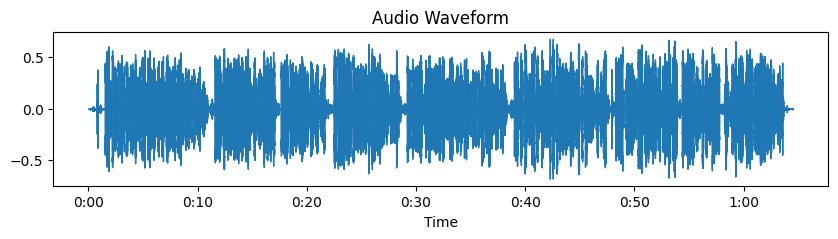

In [4]:
try:
    # Load metadata without loading the whole audio into memory
    y, sr = librosa.load(file_path, sr=None) 
    duration = librosa.get_duration(y=y, sr=sr)
    
    print(f"⏱️ Duration: {duration:.2f} seconds (approx {duration/60:.2f} minutes)")
    print(f"📢 Sample Rate: {sr} Hz")
    
    # Quick visual check to see if the audio actually has sound (not silence)
    plt.figure(figsize=(10, 2))
    librosa.display.waveshow(y, sr=sr)
    plt.title("Audio Waveform")
    plt.show()

except Exception as e:
    print(f"❌ Error reading audio properties: {e}")

Step 3: Basic Transcription (Without Chunking)

In [6]:
import io

# 1. Define the path (assuming you moved it to recordings/ or updated the path)
file_path = 'recordings/Artem audio.mpeg' 

# 2. Extract just a "short part" (first 30 seconds) using librosa
# This prevents sending a massive file if the meeting is long
short_audio, sr = librosa.load(file_path, duration=30)

# 3. Save this snippet to a buffer (in-memory file) so we don't need to save a new file to disk
buffer = io.BytesIO()
sf.write(buffer, short_audio, sr, format='wav')
buffer.seek(0)
buffer.name = "segment.wav" # Whisper needs a filename/extension to identify format

print("⏳ Sending short segment to OpenAI Whisper...")

try:
    # 4. Request transcription
    transcript = client.audio.transcriptions.create(
        model="whisper-1", 
        file=buffer
    )

    # 5. Display the result
    print("✅ Transcription Complete:\n")
    display(Markdown(f"> {transcript.text}"))

except Exception as e:
    print(f"❌ Transcription failed: {e}")

⏳ Sending short segment to OpenAI Whisper...
✅ Transcription Complete:



> Effective AI marketing in 2026 is no longer about using as many tools as possible or blindly automating everything. It's about building a smart, adaptive system that can only understand people and respond to their real needs. At its core, effective AI marketing combines data, strategy, and human insight.

Understanding the api response format

In [7]:
# The structure is much richer:
{
  "task": "transcribe",
  "language": "english",
  "duration": 30.0,
  "text": "Hello world...",
  "segments": [
    {
      "id": 0,
      "start": 0.0,
      "end": 2.5,
      "text": "Hello world",
      "avg_logprob": -0.15,  # Higher is better
      "compression_ratio": 1.2,
      "no_speech_prob": 0.01
    }
  ]
}

{'task': 'transcribe',
 'language': 'english',
 'duration': 30.0,
 'text': 'Hello world...',
 'segments': [{'id': 0,
   'start': 0.0,
   'end': 2.5,
   'text': 'Hello world',
   'avg_logprob': -0.15,
   'compression_ratio': 1.2,
   'no_speech_prob': 0.01}]}

Extract basic clean text

In [9]:
# 1. Prepare your file (using the first 30 seconds)
audio_segment, sr = librosa.load('recordings/Artem audio.mpeg', duration=30)
buffer = io.BytesIO()
sf.write(buffer, audio_segment, sr, format='wav')
buffer.seek(0)
buffer.name = "arthur.wav"

# 2. Extract plain text only
# By setting response_format="text", the result is a string, not a JSON object
simple_transcript = client.audio.transcriptions.create(
    model="whisper-1", 
    file=buffer,
    response_format="text"
)

print("📝 Clean Transcription Text:")
print(simple_transcript)

📝 Clean Transcription Text:
Effective AI marketing in 2026 is no longer about using as many tools as possible or blindly automating everything. It's about building a smart, adaptive system that can only understand people and respond to their real needs. At its core, effective AI marketing combines data, strategy, and human insight.



Saving the result

In [10]:
with open("results/Artem audio.txt", "w") as f:
    f.write(simple_transcript)
print("\n✅ Saved to results/Artem audio.txt")


✅ Saved to results/Artem audio.txt


Step 3: Creating Ground Truth Transcription

Use the Whisper transcription as a starting point

In [3]:
import os
from openai import OpenAI
from dotenv import load_dotenv

# 1. Re-load environment and initialize Client
load_dotenv("../.env") # Adjust path if your .env is elsewhere
api_key = os.getenv("OPENAI_API_KEY")
client = OpenAI(api_key=api_key)

full_file_path = 'recordings/Artem audio.mpeg'

print(f"⏳ Processing the ENTIRE file: {full_file_path}...")

try:
    # 2. Open the file in binary mode
    with open(full_file_path, "rb") as audio_file:
        full_transcript = client.audio.transcriptions.create(
            model="whisper-1", 
            file=audio_file,
            response_format="text"
        )

    # 3. Save the full version to results
    os.makedirs('results', exist_ok=True)
    output_path = "results/Artem_audio_FULL_DRAFT.txt"
    
    with open(output_path, "w") as f:
        f.write(full_transcript)

    print(f"✅ Success! Full transcription saved to: {output_path}")
    print("\n--- TEXT PREVIEW ---")
    print(full_transcript) 

except Exception as e:
    print(f"❌ Error: {e}")
    

⏳ Processing the ENTIRE file: recordings/Artem audio.mpeg...
✅ Success! Full transcription saved to: results/Artem_audio_FULL_DRAFT.txt

--- TEXT PREVIEW ---
Effective AI marketing in 2026 is no longer about using as many tools as possible or blindly automating everything. It's about building a smart, adaptive system that can only understand people and respond to their real needs. At its core, effective AI marketing combines data, strategy, and human insight. AI helps marketers analyze customer behavior in real time, predict intent, and personalize communication at scale. However, the key difference in 2026 is that AI is used to support decision-making, not replace it. The strongest brands use AI to test hypotheses faster, optimize content, and improve customer experience, while humans remain responsible for strategy, ethics, and creativity.



Step 4: Calculating Word Error Rate (WER)

Calculate de WER (Use your human-verified ground truth transcription as the reference)

In [7]:
import os
import jiwer
import re
from openai import OpenAI
from dotenv import load_dotenv

# 1. SETUP & PATHS
load_dotenv("../.env")
client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

ground_truth_path = "results/Artem_audio_ground truth manually modified.txt"
whisper_draft_path = "results/Artem_audio_FULL_DRAFT.txt"

# 2. LOAD FILES
try:
    with open(ground_truth_path, "r") as f:
        ground_truth = f.read()
    with open(whisper_draft_path, "r") as f:
        whisper_hypothesis = f.read()
    print("✅ Files loaded successfully.")
except FileNotFoundError as e:
    print(f"❌ Error: Could not find file. {e}")

# 3. DEFINE TRANSFORMATION (Standardization)
# This prevents the AI from being "punished" for commas or capital letters
transformation = jiwer.Compose([
    jiwer.ToLowerCase(),
    jiwer.RemovePunctuation(),
    jiwer.RemoveWhiteSpace(replace_by_space=True),
    jiwer.RemoveMultipleSpaces(),
    jiwer.Strip(),
])

# 4. PROCESS & CALCULATE
clean_truth = transformation(ground_truth)
clean_hypothesis = transformation(whisper_hypothesis)

# We use process_words to get the specific S, D, I counts
out = jiwer.process_words(clean_truth, clean_hypothesis)

# 5. DISPLAY RESULTS
print("\n" + "="*30)
print("📊 FINAL TRANSCRIPTION METRICS")
print("="*30)
print(f"Word Error Rate (WER): {out.wer:.4f}")
print(f"Transcription Accuracy: {(1 - out.wer) * 100:.2f}%")
print("-" * 30)
print(f"Substitutions (S): {out.substitutions}")
print(f"Deletions (D):     {out.deletions}")
print(f"Insertions (I):    {out.insertions}")
print(f"Total Reference Words: {len(clean_truth.split())}")
print("="*30)

# 6. QUICK ERROR LOG (First 10 mismatches)
print("\n🔍 SAMPLE OF DISCREPANCIES:")
truth_words = clean_truth.split()
hypo_words = clean_hypothesis.split()

mismatch_count = 0
for i in range(min(len(truth_words), len(hypo_words))):
    if truth_words[i] != hypo_words[i]:
        print(f"Line {i}: [Truth: '{truth_words[i]}'] vs [AI: '{hypo_words[i]}']")
        mismatch_count += 1
    if mismatch_count >= 10:
        break

✅ Files loaded successfully.

📊 FINAL TRANSCRIPTION METRICS
Word Error Rate (WER): 0.0571
Transcription Accuracy: 94.29%
------------------------------
Substitutions (S): 3
Deletions (D):     1
Insertions (I):    2
Total Reference Words: 105

🔍 SAMPLE OF DISCREPANCIES:
Line 19: [Truth: 'it'] vs [AI: 'its']
Line 20: [Truth: 'is'] vs [AI: 'about']
Line 21: [Truth: 'about'] vs [AI: 'building']
Line 22: [Truth: 'building'] vs [AI: 'a']
Line 25: [Truth: 'systems'] vs [AI: 'system']
Line 27: [Truth: 'genuinely'] vs [AI: 'can']
Line 28: [Truth: 'understand'] vs [AI: 'only']
Line 29: [Truth: 'people'] vs [AI: 'understand']
Line 30: [Truth: 'and'] vs [AI: 'people']
Line 31: [Truth: 'respond'] vs [AI: 'and']


Analyze the error breakdown (substitutions, insertions, deletions)

In [ ]:
The Error Breakdown Analysis

In [8]:
# Assuming 'out' from the previous block is still in memory
total_ref_words = len(clean_truth.split())

# Calculate percentages for each error type
sub_rate = (out.substitutions / total_ref_words) * 100
del_rate = (out.deletions / total_ref_words) * 100
ins_rate = (out.insertions / total_ref_words) * 100

print("🔍 ERROR ANALYSIS BREAKDOWN")
print(f"{'Error Type':<15} | {'Count':<10} | {'Impact on WER':<15}")
print("-" * 45)
print(f"{'Substitutions':<15} | {out.substitutions:<10} | {sub_rate:.2f}%")
print(f"{'Deletions':<15} | {out.deletions:<10} | {del_rate:.2f}%")
print(f"{'Insertions':<15} | {out.insertions:<10} | {ins_rate:.2f}%")
print("-" * 45)
print(f"Total Reference Words: {total_ref_words}")

🔍 ERROR ANALYSIS BREAKDOWN
Error Type      | Count      | Impact on WER  
---------------------------------------------
Substitutions   | 3          | 2.86%
Deletions       | 1          | 0.95%
Insertions      | 2          | 1.90%
---------------------------------------------
Total Reference Words: 105


Visualize the Error Profile

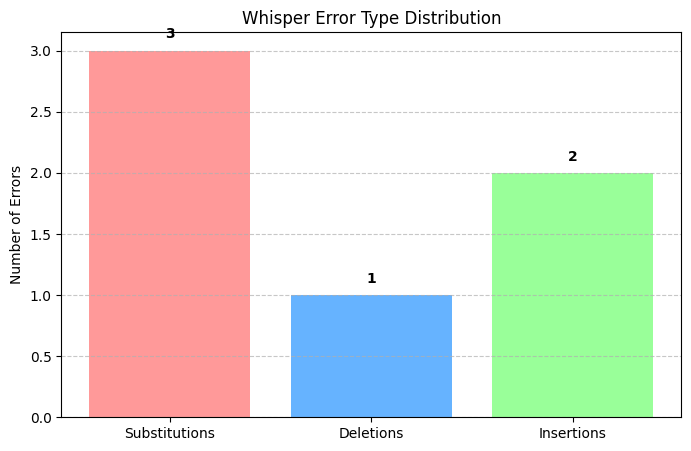

In [9]:
import matplotlib.pyplot as plt

# Data for plotting
labels = ['Substitutions', 'Deletions', 'Insertions']
counts = [out.substitutions, out.deletions, out.insertions]
colors = ['#ff9999','#66b3ff','#99ff99']

plt.figure(figsize=(8, 5))
plt.bar(labels, counts, color=colors)
plt.title('Whisper Error Type Distribution')
plt.ylabel('Number of Errors')
plt.grid(axis='y', linestyle='--', alpha=0.7)

for i, v in enumerate(counts):
    plt.text(i, v + 0.1, str(v), ha='center', fontweight='bold')

plt.show()

Verify that WER is calculated correctly

In [10]:
import re

def manual_wer_check(reference, hypothesis):
    # 1. Clean and split into word lists
    def clean(text):
        return re.sub(r'[^\w\s]', '', text.lower()).split()
    
    ref_words = clean(reference)
    hyp_words = clean(hypothesis)
    N = len(ref_words)
    
    # 2. Create the Levenshtein Matrix
    import numpy as np
    rows = N + 1
    cols = len(hyp_words) + 1
    dist = np.zeros((rows, cols), dtype=int)
    
    for i in range(rows): dist[i][0] = i
    for j in range(cols): dist[0][j] = j
    
    for i in range(1, rows):
        for j in range(1, cols):
            if ref_words[i-1] == hyp_words[j-1]:
                dist[i][j] = dist[i-1][j-1]
            else:
                dist[i][j] = min(dist[i-1][j-1] + 1, # Substitution
                                 dist[i][j-1] + 1,   # Insertion
                                 dist[i-1][j] + 1)   # Deletion
    
    raw_error_count = dist[N][len(hyp_words)]
    wer = raw_error_count / N if N > 0 else 0
    
    return wer, N, raw_error_count

# Load your files
with open("results/Artem_audio_ground truth manually modified.txt", "r") as f:
    truth = f.read()
with open("results/Artem_audio_FULL_DRAFT.txt", "r") as f:
    draft = f.read()

wer, total_words, errors = manual_wer_check(truth, draft)

print(f"--- MANUAL VERIFICATION ---")
print(f"Total Reference Words (N): {total_words}")
print(f"Total Edit Distance (S+D+I): {errors}")
print(f"Calculated WER: {wer:.4f}")
print(f"Calculated Accuracy: {(1-wer)*100:.2f}%")

--- MANUAL VERIFICATION ---
Total Reference Words (N): 105
Total Edit Distance (S+D+I): 6
Calculated WER: 0.0571
Calculated Accuracy: 94.29%


Step 5: Cost Analysis

In [ ]:
Calculate costs based on audio duration

In [12]:
import librosa
import os
import warnings

# Suppress warnings to keep the output clean
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)

def calculate_transcription_costs(file_path):
    # 1. Load duration without loading full audio into memory
    # (Much faster for cost estimation)
    duration_seconds = librosa.get_duration(path=file_path)
    duration_minutes = duration_seconds / 60
    
    # 2. Updated 2026 Rates
    rates = {
        "GPT-4o Mini": 0.003,
        "Whisper Standard": 0.006,
        "GPT-4o Transcribe": 0.006
    }
    
    # 3. Print Results Table
    print(f"📊 COST ANALYSIS FOR: {os.path.basename(file_path)}")
    print(f"⏱️ Total Duration: {duration_minutes:.2f} minutes")
    print("-" * 45)
    print(f"{'Model Tier':<20} | {'Estimated Cost':<15}")
    print("-" * 45)
    
    for model, rate in rates.items():
        cost = duration_minutes * rate
        # Using 4 decimal places since costs can be very small
        print(f"{model:<20} | ${cost:.4f}")
    print("-" * 45)

# Use your actual recording path
file_path = 'recordings/Artem audio.mpeg'
if os.path.exists(file_path):
    calculate_transcription_costs(file_path)
else:
    print("❌ File not found. Please check your path.")

📊 COST ANALYSIS FOR: Artem audio.mpeg
⏱️ Total Duration: 1.08 minutes
---------------------------------------------
Model Tier           | Estimated Cost 
---------------------------------------------
GPT-4o Mini          | $0.0032
Whisper Standard     | $0.0065
GPT-4o Transcribe    | $0.0065
---------------------------------------------


Model Tier	        Best For	                        Price per Minute	Price per Hour
GPT-4o Mini         Transcribe	High-volume / Budget	    $0.0030	            $0.18
Whisper (Standard)	Legacy / Word-timestamps	            $0.0060	            $0.36
GPT-4o Transcribe	High accuracy / Accents	                $0.0060	            $0.36
GPT-4o Diarize	    Multi-speaker identification	        $0.0060	            $0.36

Estimate costs for different volumes

In [14]:
import pandas as pd

def display_cost_table():
    # 1. Define the Durations
    durations = {
        "1 Minute": 1,
        "30 Minutes": 30,
        "1 Hour": 60,
        "1 Day (24h)": 1440
    }
    
    # 2. Define 2026 Rates (Price per minute)
    whisper_rate = 0.006
    gpt4o_mini_rate = 0.003
    
    # 3. Calculate costs
    data = []
    for label, mins in durations.items():
        whisper_cost = mins * whisper_rate
        mini_cost = mins * gpt4o_mini_rate
        data.append({
            "Duration": label,
            "Whisper Standard ($0.006/m)": f"${whisper_cost:,.3f}",
            "GPT-4o Mini ($0.003/m)": f"${mini_cost:,.3f}",
            "Savings": f"${(whisper_cost - mini_cost):,.3f}"
        })
    
    # 4. Create and display DataFrame
    df = pd.DataFrame(data)
    
    print("💰 --- OPENAI TRANSCRIPTION COST ESTIMATE (2026) ---")
    print(df.to_string(index=False))
    print("\n*Note: Costs are calculated based on duration-based billing.*")

# Run the function
display_cost_table()

💰 --- OPENAI TRANSCRIPTION COST ESTIMATE (2026) ---
   Duration Whisper Standard ($0.006/m) GPT-4o Mini ($0.003/m) Savings
   1 Minute                      $0.006                 $0.003  $0.003
 30 Minutes                      $0.180                 $0.090  $0.090
     1 Hour                      $0.360                 $0.180  $0.180
1 Day (24h)                      $8.640                 $4.320  $4.320

*Note: Costs are calculated based on duration-based billing.*


To optime costs

Delete silences: Voice Activity Detection (VAD) - "The Silence Stripper"

In [15]:
# Conceptual logic for VAD optimization
original_duration = 60.0  # minutes
silence_removed = 15.0    # minutes
optimized_duration = 45.0

savings = silence_removed * 0.006
print(f"By removing silence, you saved: ${savings:.2f}")

By removing silence, you saved: $0.09


Audio Pre-Processing (Downsampling)

While it doesn't reduce the "price per minute," reducing the file size speeds up upload times and reduces storage costs. Tool: Use ffmpeg or pydub. Smaller files also help avoid the 25MB file size limit of the standard Whisper API.

Using the OpenAI Batch API (50% Discount) in contrast to real - time transcriptions